In [1]:
import pandas as pd
import numpy as np
import re
import os

import seaborn as sns
import matplotlib.pyplot as plt

### 0. Imports and Utils

In [2]:
# Let's define some hyper-parameters
hparams = {
  'output_data_path': 'C:\\Users\\danie\\Documents\\TFM\\tfm\\output_data',
  'audio_embedding_model': 'uniSpeechSat'
}

In [3]:
def load_train_logs():

    data_dict = {}

    loss_pattern = r"Loss: (\d+\.\d+)"
    avg_loss_pattern = r"Avg Loss: (\d+\.\d+)"
    avg_acc_pattern = r"Avg Acc: (\d+\.\d+)%"
    avg_urs_pattern = r"Avg URS: (\d+\.\d+)%"

    approaches_folders = os.listdir(hparams['output_data_path'])

    for approach_folder in approaches_folders:
        approach_folder = os.path.join(hparams['output_data_path'], approach_folder)
        text_seeds_folders = os.listdir(approach_folder)

        for text_seed_folder in text_seeds_folders:
            text_seed_folder = os.path.join(approach_folder, text_seed_folder)
            experiments_folders = os.listdir(text_seed_folder)
            
            for experiment_folder in experiments_folders:
                experiment_name = experiment_folder
                experiment_folder = os.path.join(text_seed_folder, experiment_folder)

                experiment_data = {'loss': list(),
                                   'avg_loss': list(),
                                   'avg_acc': list(),
                                   'avg_urs': list()}

                with open(experiment_folder + '\\train.log') as f:
                    
                    lines = [line.rstrip() for line in f]

                    for line in lines:
                        if 'Train Epoch' not in line:
                            continue
                        
                        loss_match = re.search(loss_pattern, line).group(1)
                        experiment_data['loss'].append(float(loss_match))

                        avg_loss_match = re.search(avg_loss_pattern, line).group(1)
                        experiment_data['avg_loss'].append(float(avg_loss_match))

                        avg_acc_match = re.search(avg_acc_pattern, line).group(1)
                        experiment_data['avg_acc'].append(float(avg_acc_match))

                        avg_urs_match = re.search(avg_urs_pattern, line).group(1)
                        experiment_data['avg_urs'].append(float(avg_urs_match))

                data_dict[experiment_name] = experiment_data
                
    return data_dict

In [4]:
def load_metrics_logs():

    data_dict = {}

    pattern_list = r"([\w_]+):\s?(\[.*?\])"
    pattern_value = r"([\w_]+):\s?(\d+\.\d+)"

    approaches_folders = os.listdir(hparams['output_data_path'])

    for approach_folder in approaches_folders:
        approach_folder = os.path.join(hparams['output_data_path'], approach_folder)
        text_seeds_folders = os.listdir(approach_folder)

        for text_seed_folder in text_seeds_folders:
            text_seed_folder = os.path.join(approach_folder, text_seed_folder)
            experiments_folders = os.listdir(text_seed_folder)
            
            for experiment_folder in experiments_folders:
                experiment_name = experiment_folder
                experiment_folder = os.path.join(text_seed_folder, experiment_folder)

                experiment_data = dict()

                with open(experiment_folder + '\\metrics.log') as f:
                    lines = [line.rstrip() for line in f]

                    for line in lines:
                        # Extract values using regular expressions
                        matches = re.findall(pattern_list, line)
                        
                        # Store values in dictionaries
                        for key, value in matches:
                            value = eval(value)
                            experiment_data[key] = value

                        # Extract values using regular expressions
                        matches = re.findall(pattern_value, line)
                        
                        # Store values in dictionaries
                        for key, value in matches:
                            value = eval(value)
                            experiment_data[key] = value
                        
                data_dict[experiment_name] = experiment_data
                
    return data_dict

In [5]:
# Define the confidence level (e.g., 95%)
confidence_level = 0.95
z_score = 1.96  # For 95% confidence interval

def get_mean_with_margin_evolution(data):
    
    global confidence_level, z_score

    # Calculate the mean and standard deviation across experiments for each time point
    mean_data = np.mean(data, axis=0)
    std_data = np.std(data, axis=0)

    # Calculate the margin of error
    margin_of_error = z_score * (std_data / np.sqrt(len(data)))

    return mean_data, margin_of_error

In [6]:
def plot_text_audio_metric_evolution(mean_metric_gpt2, margin_of_error_gpt2,
                                     mean_metric_audio, margin_of_error_audio,
                                     label_gpt='Average GPT2 Only',
                                     label_audio='Average GPT2 & W2V2',
                                     x_axis_label='Iterations',
                                     y_axis_label='Cross-Entropy Loss',
                                     title='Loss evolution'):
    
    # Plot the average line
    plt.plot(np.concatenate((mean_metric_gpt2, mean_metric_audio)), label=label_audio, color='red')
    # Plot the confidence interval
    plt.fill_between(range(len(np.concatenate((mean_metric_gpt2, mean_metric_audio)))),
                    np.concatenate((mean_metric_gpt2, mean_metric_audio)) - np.concatenate((margin_of_error_gpt2, margin_of_error_audio)),
                    np.concatenate((mean_metric_gpt2, mean_metric_audio)) + np.concatenate((margin_of_error_gpt2, margin_of_error_audio)),
                    color='red', alpha=0.20,)

    # Plot the average line
    plt.plot(mean_metric_gpt2, label=label_gpt, color='blue')
    # Plot the confidence interval
    plt.fill_between(range(len(mean_metric_gpt2)), mean_metric_gpt2 - margin_of_error_gpt2, mean_metric_gpt2 + margin_of_error_gpt2,
                    color='blue', alpha=0.20,)

    # Add labels and legend
    plt.ylim(ymin=0)  # this line
    plt.xlim(xmin=0)  # this line
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.title(title)
    plt.grid()
    plt.legend()

    # Show the plot
    plt.show()

### 1. Load data

In [7]:
train_dict = load_train_logs()

In [8]:
#filter to keep only only transcript and the audio embedding model to be studied
keys_to_drop = list()

for key in train_dict.keys():
    if not ('gpt2_transcript_seed_' in key or (hparams['audio_embedding_model'] in key and 'asr' not in key)):
        keys_to_drop.append(key)
        
for key in keys_to_drop:
    del train_dict[key]

In [9]:
print("Experiments found:")
for key in train_dict.keys():
    print(key)

Experiments found:
1.2.gpt2_transcript_seed_0
1.1.gpt2_transcript_seed_42
1.3.gpt2_transcript_seed_84
1.gpt2_uniSpeechSat_transcript_prevseed_0_currentseed_42
2.gpt2_uniSpeechSat_transcript_prevseed_0_currentseed_0
3.gpt2_uniSpeechSat_transcript_prevseed_0_currentseed_84
1.gpt2_uniSpeechSat_transcript_prevseed_42_currentseed_42
2.gpt2_uniSpeechSat_transcript_prevseed_42_currentseed_0
3.gpt2_uniSpeechSat_transcript_prevseed_42_currentseed_84
1.gpt2_uniSpeechSat_transcript_prevseed_84_currentseed_42
2.gpt2_uniSpeechSat_transcript_prevseed_84_currentseed_0
3.gpt2_uniSpeechSat_transcript_prevseed_84_currentseed_84


In [10]:
metrics_dict = load_metrics_logs()

In [11]:
for key in keys_to_drop:
    del metrics_dict[key]

In [12]:
print("Experiments found:")
for key in metrics_dict.keys():
    print(key)

Experiments found:
1.2.gpt2_transcript_seed_0
1.1.gpt2_transcript_seed_42
1.3.gpt2_transcript_seed_84
1.gpt2_uniSpeechSat_transcript_prevseed_0_currentseed_42
2.gpt2_uniSpeechSat_transcript_prevseed_0_currentseed_0
3.gpt2_uniSpeechSat_transcript_prevseed_0_currentseed_84
1.gpt2_uniSpeechSat_transcript_prevseed_42_currentseed_42
2.gpt2_uniSpeechSat_transcript_prevseed_42_currentseed_0
3.gpt2_uniSpeechSat_transcript_prevseed_42_currentseed_84
1.gpt2_uniSpeechSat_transcript_prevseed_84_currentseed_42
2.gpt2_uniSpeechSat_transcript_prevseed_84_currentseed_0
3.gpt2_uniSpeechSat_transcript_prevseed_84_currentseed_84


### 1. Loss evolution during training

In [13]:
loss_all_experiments_gpt2 = [np.array(train_dict[key]['loss']) for key in train_dict if 'prevseed' not in key]
loss_all_experiments_gpt2 = np.array(loss_all_experiments_gpt2)

mean_loss_gpt2, margin_of_error_gpt2 = get_mean_with_margin_evolution(loss_all_experiments_gpt2)

In [14]:
loss_all_experiments_audio = [np.array(train_dict[key]['loss']) for key in train_dict if 'prevseed' in key]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

mean_loss_audio, margin_of_error_audio = get_mean_with_margin_evolution(loss_all_experiments_audio)

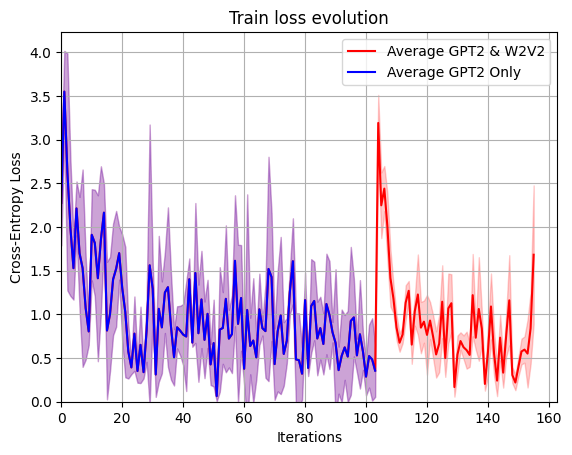

In [15]:
plot_text_audio_metric_evolution(mean_loss_gpt2, margin_of_error_gpt2,
                                 mean_loss_audio, margin_of_error_audio,
                                 title='Train loss evolution',
                                 x_axis_label='Iterations',
                                 y_axis_label='Cross-Entropy Loss')

### 2. Accuracy evolution during training

In [16]:
loss_all_experiments_gpt2 = [np.array(train_dict[key]['avg_acc']) for key in train_dict if 'prevseed' not in key]
loss_all_experiments_gpt2 = np.array(loss_all_experiments_gpt2)

mean_loss_gpt2, margin_of_error_gpt2 = get_mean_with_margin_evolution(loss_all_experiments_gpt2)

In [17]:
loss_all_experiments_audio = [np.array(train_dict[key]['avg_acc']) for key in train_dict if 'prevseed' in key]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

mean_loss_audio, margin_of_error_audio = get_mean_with_margin_evolution(loss_all_experiments_audio)

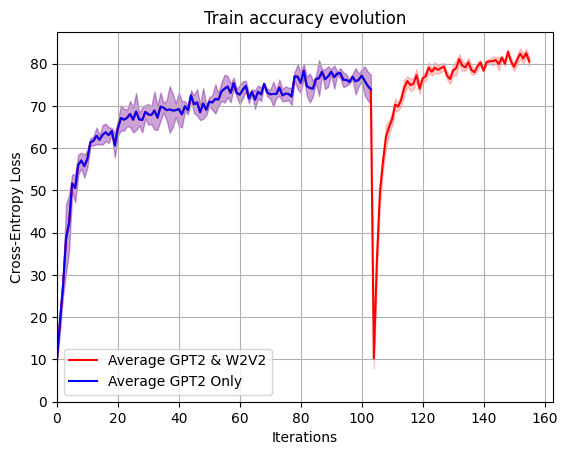

In [18]:
plot_text_audio_metric_evolution(mean_loss_gpt2, margin_of_error_gpt2,
                                 mean_loss_audio, margin_of_error_audio,
                                 title='Train accuracy evolution',
                                 x_axis_label='Iterations',
                                 y_axis_label='Cross-Entropy Loss')

### 3. URS evolution during training

In [19]:
loss_all_experiments_gpt2 = [np.array(train_dict[key]['avg_urs']) for key in train_dict if 'prevseed' not in key]
loss_all_experiments_gpt2 = np.array(loss_all_experiments_gpt2)

mean_loss_gpt2, margin_of_error_gpt2 = get_mean_with_margin_evolution(loss_all_experiments_gpt2)

In [20]:
loss_all_experiments_audio = [np.array(train_dict[key]['avg_urs']) for key in train_dict if 'prevseed' in key]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

mean_loss_audio, margin_of_error_audio = get_mean_with_margin_evolution(loss_all_experiments_audio)

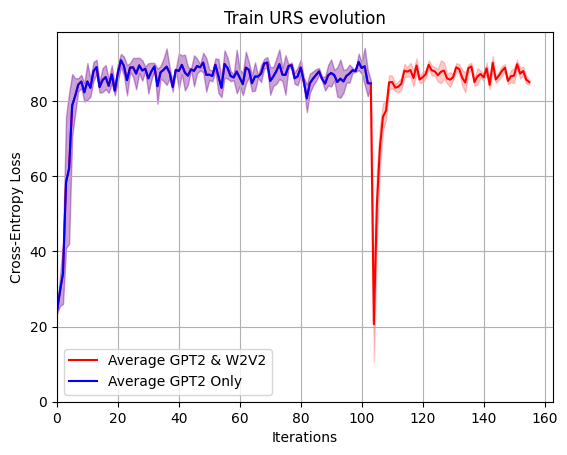

In [21]:
plot_text_audio_metric_evolution(mean_loss_gpt2, margin_of_error_gpt2,
                                 mean_loss_audio, margin_of_error_audio,
                                 title='Train URS evolution',
                                 x_axis_label='Iterations',
                                 y_axis_label='Cross-Entropy Loss')

### 3.1. Loss

In [22]:
loss_all_experiments_gpt2 = [np.array(metrics_dict[key]['train_loss'][-1]) for key in train_dict if 'prevseed' not in key]
loss_all_experiments_gpt2 = np.array(loss_all_experiments_gpt2)

loss_all_experiments_audio = [np.array(metrics_dict[key]['train_loss'][-1]) for key in train_dict if 'prevseed' in key]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean train loss gpt2: {np.mean(loss_all_experiments_gpt2)}")
print(f"mean train loss gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}")

mean train loss gpt2: 0.7039038967296166
mean train loss gpt2 + uniSpeechSat: 0.6296965191290832


In [23]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_train_loss: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_train_loss: {np.std(loss_all_experiments_audio)}\n')
    file.write(f'mean_train_loss_improvement: {(np.mean(np.mean(loss_all_experiments_audio)) - np.mean(loss_all_experiments_gpt2)) / np.mean(loss_all_experiments_gpt2) * 100}\n')

In [24]:
loss_all_experiments_gpt2 = [np.array(metrics_dict[key]['dev_loss'][-1]) for key in train_dict if 'prevseed' not in key]
loss_all_experiments_gpt2 = np.array(loss_all_experiments_gpt2)

loss_all_experiments_audio = [np.array(metrics_dict[key]['dev_loss'][-1]) for key in train_dict if 'prevseed' in key]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean dev loss gpt2:{np.mean(loss_all_experiments_gpt2)}")
print(f"mean dev loss gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}")

mean dev loss gpt2:0.9200813128834678
mean dev loss gpt2 + uniSpeechSat: 0.8910803551711735


In [25]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_dev_loss: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_dev_loss: {np.std(loss_all_experiments_audio)}\n')
    file.write(f'mean_dev_loss_improvement: {(np.mean(np.mean(loss_all_experiments_audio)) - np.mean(loss_all_experiments_gpt2)) / np.mean(loss_all_experiments_gpt2) * 100}\n')

In [26]:
loss_all_experiments_gpt2 = [np.array(metrics_dict[key]['test_loss']) for key in train_dict if 'prevseed' not in key]
loss_all_experiments_gpt2 = np.array(loss_all_experiments_gpt2)

loss_all_experiments_audio = [np.array(metrics_dict[key]['test_loss']) for key in train_dict if 'prevseed' in key]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean test loss gpt2: {np.mean(loss_all_experiments_gpt2)}")
print(f"mean test loss gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}")

mean test loss gpt2: 3.4776484442479685
mean test loss gpt2 + uniSpeechSat: 2.939998105318859


In [27]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_test_loss: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_test_loss: {np.std(loss_all_experiments_audio)}\n')
    file.write(f'mean_test_loss_improvement: {(np.mean(np.mean(loss_all_experiments_audio)) - np.mean(loss_all_experiments_gpt2)) / np.mean(loss_all_experiments_gpt2) * 100}\n')

### 3.2. Accuracy

In [28]:
loss_all_experiments_gpt2 = [np.array(metrics_dict[key]['train_accuracy'][-1]) for key in train_dict if 'prevseed' not in key]
loss_all_experiments_gpt2 = np.array(loss_all_experiments_gpt2)

loss_all_experiments_audio = [np.array(metrics_dict[key]['train_accuracy'][-1]) for key in train_dict if 'prevseed' in key]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean train accuracy gpt2: {np.mean(loss_all_experiments_gpt2)}")
print(f"mean train accuracy gpt2 + {hparams['audio_embedding_model']} :{np.mean(np.mean(loss_all_experiments_audio))}")

mean train accuracy gpt2: 76.4066898493128
mean train accuracy gpt2 + uniSpeechSat :80.16448639399458


In [29]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_train_accuracy: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_train_accuracy: {np.std(loss_all_experiments_audio)}\n')
    file.write(f'mean_train_accuracy_improvement: {(np.mean(np.mean(loss_all_experiments_audio)) - np.mean(loss_all_experiments_gpt2)) / np.mean(loss_all_experiments_gpt2) * 100}\n')

In [30]:
loss_all_experiments_gpt2 = [np.array(metrics_dict[key]['dev_accuracy'][-1]) for key in train_dict if 'prevseed' not in key]
loss_all_experiments_gpt2 = np.array(loss_all_experiments_gpt2)

loss_all_experiments_audio = [np.array(metrics_dict[key]['dev_accuracy'][-1]) for key in train_dict if 'prevseed' in key]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean dev accuracy gpt2: {np.mean(loss_all_experiments_gpt2)}")
print(f"mean dev accuracy gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}")

mean dev accuracy gpt2: 71.31466355503694
mean dev accuracy gpt2 + uniSpeechSat: 71.54803578374174


In [31]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_dev_accuracy: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_dev_accuracy: {np.std(loss_all_experiments_audio)}\n')
    file.write(f'mean_dev_accuracy_improvement: {(np.mean(np.mean(loss_all_experiments_audio)) - np.mean(loss_all_experiments_gpt2)) / np.mean(loss_all_experiments_gpt2) * 100}\n')

In [32]:
loss_all_experiments_gpt2 = [np.array(metrics_dict[key]['test_accuracy']) for key in train_dict if 'prevseed' not in key]
loss_all_experiments_gpt2 = np.array(loss_all_experiments_gpt2)

loss_all_experiments_audio = [np.array(metrics_dict[key]['test_accuracy']) for key in train_dict if 'prevseed' in key]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean test accuracy gpt2: {np.mean(loss_all_experiments_gpt2)}")
print(f"mean test accuracy gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}")

mean test accuracy gpt2: 47.73357650366655
mean test accuracy gpt2 + uniSpeechSat: 47.47394151246882


In [33]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_test_accuracy: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_test_accuracy: {np.std(loss_all_experiments_audio)}\n')
    file.write(f'mean_test_accuracy_improvement: {(np.mean(np.mean(loss_all_experiments_audio)) - np.mean(loss_all_experiments_gpt2)) / np.mean(loss_all_experiments_gpt2) * 100}\n')

### 3.3.URS

In [34]:
loss_all_experiments_gpt2 = [np.array(metrics_dict[key]['train_urs'][-1]) for key in train_dict if 'prevseed' not in key]
loss_all_experiments_gpt2 = np.array(loss_all_experiments_gpt2)

loss_all_experiments_audio = [np.array(metrics_dict[key]['train_urs'][-1]) for key in train_dict if 'prevseed' in key]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean train URS gpt2 :{np.mean(loss_all_experiments_gpt2)}")
print(f"mean train URS gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}")

mean train URS gpt2 :86.53666666666668
mean train URS gpt2 + uniSpeechSat: 87.19309482416811


In [35]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_train_urs: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_train_urs: {np.std(loss_all_experiments_audio)}\n')
    file.write(f'mean_train_urs_improvement: {(np.mean(np.mean(loss_all_experiments_audio)) - np.mean(loss_all_experiments_gpt2)) / np.mean(loss_all_experiments_gpt2) * 100}\n')

In [36]:
loss_all_experiments_gpt2 = [np.array(metrics_dict[key]['dev_urs'][-1]) for key in train_dict if 'prevseed' not in key]
loss_all_experiments_gpt2 = np.array(loss_all_experiments_gpt2)

loss_all_experiments_audio = [np.array(metrics_dict[key]['dev_urs'][-1]) for key in train_dict if 'prevseed' in key]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean dev URS gpt2:{np.mean(loss_all_experiments_gpt2)}")
print(f"mean dev URS gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}")

mean dev URS gpt2:89.08934707903781
mean dev URS gpt2 + uniSpeechSat: 90.32073310423827


In [37]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_dev_urs: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_dev_urs: {np.std(loss_all_experiments_audio)}\n')
    file.write(f'mean_dev_urs_improvement: {(np.mean(np.mean(loss_all_experiments_audio)) - np.mean(loss_all_experiments_gpt2)) / np.mean(loss_all_experiments_gpt2) * 100}\n')

In [38]:
loss_all_experiments_gpt2 = [np.array(metrics_dict[key]['test_urs']) for key in train_dict if 'prevseed' not in key]
loss_all_experiments_gpt2 = np.array(loss_all_experiments_gpt2)

loss_all_experiments_audio = [np.array(metrics_dict[key]['test_urs']) for key in train_dict if 'prevseed' in key]
loss_all_experiments_audio = np.array(loss_all_experiments_audio)

print(f"mean test URS gpt2:{np.mean(loss_all_experiments_gpt2)}")
print(f"mean test URS gpt2 + {hparams['audio_embedding_model']}: {np.mean(np.mean(loss_all_experiments_audio))}")

mean test URS gpt2:86.79920477137176
mean test URS gpt2 + uniSpeechSat: 87.55908990501435


In [39]:
with open(f"{hparams['audio_embedding_model']}_output.txt", 'a') as file:
    file.write(f'mean_test_urs: {np.mean(np.mean(loss_all_experiments_audio))}\n')
    file.write(f'std_test_urs: {np.std(loss_all_experiments_audio)}\n')
    file.write(f'mean_test_urs_improvement: {(np.mean(np.mean(loss_all_experiments_audio)) - np.mean(loss_all_experiments_gpt2)) / np.mean(loss_all_experiments_gpt2) * 100}\n')